In [4]:
import pandas as pd
import numpy as np
# import sweetviz as sv
from matplotlib import pyplot as plt

In [5]:
df = pd.read_csv('data.csv')

In [6]:
df.head()

,order_id_new,order_try_id_new,calc_created,metered_price,upfront_price,distance,duration,gps_confidence,entered_by,b_state,...,device_token,rider_app_version,order_state,order_try_state,driver_app_version,driver_device_uid_new,device_name,eu_indicator,overpaid_ride_ticket,fraud_score
0,22,22,2020-02-02 3:37:31,4.04,10.0,2839,700,1,client,finished,...,NaN,CI.4.17,finished,finished,DA.4.37,1596,Xiaomi Redmi 6,1,0,-1383.0
1,618,618,2020-02-08 2:26:19,6.09,3.6,5698,493,1,client,finished,...,NaN,CA.5.43,finished,finished,DA.4.39,1578,Samsung SM-G965F,1,0,NaN
2,657,657,2020-02-08 11:50:35,4.32,3.5,4426,695,1,client,finished,...,NaN,CA.5.43,finished,finished,DA.4.37,951,Samsung SM-A530F,1,0,-166.0
3,313,313,2020-02-05 6:34:54,72871.72,NaN,49748,1400,0,client,finished,...,NaN,CA.5.23,finished,finished,DA.4.37,1587,TECNO-Y6,0,1,NaN
4,1176,1176,2020-02-13 17:31:24,20032.50,19500.0,10273,5067,1,client,finished,...,NaN,CA.5.04,finished,finished,DA.4.37,433,Itel W5504,0,0,NaN


In [7]:
df.shape

(4943, 26)

два каких-то id.

In [8]:
# df[df.order_id_new != df.order_try_id_new]
# есть разногласия на 1.

### избавление от дубликатов

Всего дубликатов по ID.

In [9]:
df.shape[0] - df.drop_duplicates('order_id_new').shape[0]

777

Проверка ниже показывает, что при одном ID время создания поездки всегда одинаковое.

In [10]:
df.drop_duplicates(['order_id_new', 'calc_created', 'overpaid_ride_ticket']).shape == \
df.drop_duplicates(['order_id_new', 'overpaid_ride_ticket']).shape

True

Но проблема в том, что иногда при абсолютно всех похожих данных у поездок с одним ID отличается целевая переменная - overpaid_ride_ticket. Целых 104 раза. Мы будем оставлять записи, которые имеют overpaid_ride_ticket == 1.

In [11]:
df.drop_duplicates(['order_id_new', 'overpaid_ride_ticket']).order_id_new.value_counts()

686     2
2353    2
933     2
3524    2
63      2
       ..
1447    1
1705    1
2423    1
2450    1
3636    1
Name: order_id_new, Length: 4166, dtype: int64

In [12]:
(df.drop_duplicates(['order_id_new', 'overpaid_ride_ticket']).order_id_new.value_counts() == 2).sum()

104

Находим ID таких поездок с разной целевой переменной. И создаём таблицу, которую мы сольём с основной.

In [13]:
id_cnt = (df.drop_duplicates(['order_id_new', 'overpaid_ride_ticket']).order_id_new.value_counts() == 2)

In [14]:
id_dup = id_cnt[id_cnt].index

In [15]:
df_one_version_dup = df[df.order_id_new.isin(id_dup) & df.overpaid_ride_ticket == 1].drop_duplicates('order_id_new')

In [16]:
df.shape

(4943, 26)

Удаляем дубликаты по ID, сохраняем кол-во в переменную. (Вдруг такой серверный сбой как-нибудь влияет на итоговую переменную). Но надо быть осторожным, ведь мы фильтровали некоторые дубли в сторону единиц в таргете).

In [17]:
cnt_ix = df.order_id_new.value_counts().reset_index()

In [18]:
cnt_ix.rename(columns={'order_id_new': 'cnt'}, inplace=True)

In [19]:
df = df.drop_duplicates('order_id_new').merge(cnt_ix, how='left', left_on='order_id_new', right_on='index')

Избавляемся от ID, которые мы нашли. Они остались после удаления дубликатов на предыдущем шаге. И объединяем с таблицей, которую мы нашли ранее.

In [20]:
df = df.loc[~df.order_id_new.isin(id_dup)]

In [21]:
df.shape

(4062, 28)

In [22]:
df = pd.concat([df, df_one_version_dup], axis=0)

In [23]:
df.shape

(4166, 28)

In [24]:
df = df.drop(columns=['index', 'ticket_id_new']).reset_index(drop=True)

In [25]:
pd.read_csv('data.csv').drop_duplicates('order_id_new').shape[0] == df.shape[0]

True

Теперь действительно нет дубликатов по ID заказа. И не удалили лишние записи.

### Оценка целевой переменной

Наблюдаем сильный дисбаланс классов.

In [23]:
df.overpaid_ride_ticket.value_counts()

0    3857
1     309
Name: overpaid_ride_ticket, dtype: int64

In [24]:
# %matplotlib inline

In [25]:
df.overpaid_ride_ticket.value_counts().plot.bar()
# plt.show()

<AxesSubplot:>

Европа и целевая переменная

In [26]:
df.eu_indicator.value_counts()

1    2484
0    1682
Name: eu_indicator, dtype: int64

Внезапно замечаем, что большинство переплат за поездки были не в Европе

In [27]:
pd.DataFrame(df.groupby('eu_indicator').overpaid_ride_ticket.value_counts())

overpaid_ride_ticket
eu_indicator overpaid_ride_ticket                      
0            0                                     1386
             1                                      296
1            0                                     2471
             1                                       13

### Data cleaning

Я понял, что не могу вырезать значения налево и направо. Да, есть выбросы - нулевые или почти нулевые значения, но непонятно, что с ними можно адекватного сделать.

### Feature engineering

In [26]:
df['calc_created'] = pd.to_datetime(df.calc_created)
df['time'] = df.calc_created.dt.time
df['hour'] = df.calc_created.dt.hour
df['month'] = df.calc_created.dt.month
df['over_distance'] = df.distance - df.predicted_distance
df['over_duration'] = df.duration - df.predicted_duration
df['over_price'] = df.upfront_price - df.metered_price

In [59]:
df.to_csv('data_cleaned.csv', index=None, sep=';')

In [49]:
# advert_report = sv.analyze(df)
# advert_report.show_html('sweet_df.html')

Со смартфоном нельзя связать. Понятно, что в другом регионе используются другие устройства (Tecno). Но нет связи с переплатой. Распределение слов очень похожее.   
Но почему тогда это значимая переменная в модели?

In [29]:
total_words = []
for row in df.device_name.str.split(r'[\W]'):
    for word in row:
        if len(word) > 1:
            total_words.append(word.lower())
            
total_words_over = []
for row in df[df.overpaid_ride_ticket == 1].device_name.str.split(r'[\W]'):
    for word in row:
        if len(word) > 1:
            total_words_over.append(word.lower())

### Расследование смартфона v2

In [50]:
import re

In [63]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression

In [159]:
vec = CountVectorizer(min_df=5, tokenizer=lambda x: re.split(r'[^a-zA-Z]', x))

In [160]:
matrix = vec.fit_transform(df[df.eu_indicator == 0].device_name)

In [161]:
matrix

<1682x75 sparse matrix of type '<class 'numpy.int64'>'
	with 6999 stored elements in Compressed Sparse Row format>

In [162]:
lr = LinearRegression()

In [184]:
lr.fit(matrix, df[df.eu_indicator == 0].gps_confidence)

LinearRegression()

In [185]:
names = pd.Series(vec.get_feature_names()).sort_values()

In [186]:
pd.Series({i: j for i, j in zip(names, lr.coef_)}).sort_values()

xiaomi    -0.723561
gt        -0.631227
fujitsu   -0.614053
tg        -0.510909
foxconn   -0.510909
             ...   
phantom    0.585821
lx         0.613049
lc         0.626032
ax         0.627996
lb         0.660334
Length: 75, dtype: float64

In [187]:
print(pd.Series({i: j for i, j in zip(names, lr.coef_)}).sort_values().to_string())

xiaomi     -0.723561
gt         -0.631227
fujitsu    -0.614053
tg         -0.510909
foxconn    -0.510909
fw         -0.479312
m          -0.311202
alps       -0.310435
infinix    -0.237259
samsung    -0.225570
itel       -0.198060
ta         -0.166225
sony       -0.159990
huawei     -0.154286
mobile     -0.150941
lite       -0.127800
b          -0.094678
e          -0.075256
tecno      -0.069233
c          -0.060299
d          -0.054407
iris       -0.048779
htc        -0.047705
global     -0.039614
hmd        -0.039614
pro        -0.036451
cph         0.023157
sm          0.024473
g           0.030184
j           0.052399
p           0.064203
            0.069475
limited     0.076724
trt         0.105099
nokia       0.126611
camon       0.149157
air         0.149157
y           0.150640
oppo        0.184323
t           0.191314
plus        0.210866
l           0.225627
mobility    0.227666
iphone      0.234254
w           0.267571
k           0.275931
lava        0.279382
a           0

In [177]:
lr.fit(matrix, df[df.eu_indicator == 0].overpaid_ride_ticket)

LinearRegression()

In [178]:
names = pd.Series(vec.get_feature_names()).sort_values()

In [181]:
pd.Series({i: j for i, j in zip(names, lr.coef_)}).sort_values()

lc     -0.333826
cc     -0.332411
la     -0.332300
kb     -0.312177
iris   -0.307687
          ...   
sm      0.179632
lava    0.331176
htc     0.369271
y       0.437828
gt      0.787539
Length: 75, dtype: float64

### Some ML

In [30]:
import catboost

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
num_features = ['hour', 'eu_indicator', 'fraud_score', 'predicted_distance', 'predicted_duration',\
               'gps_confidence', 'duration', 'distance', 'upfront_price', 'metered_price', ]
cat_features = ['entered_by', 'prediction_price_type', 'change_reason_pricing', 'rider_app_version', 'driver_app_version',\
               'device_name', 'dest_change_number', 'month']

In [33]:
y = df[df.eu_indicator == 0].overpaid_ride_ticket
X = df[df.eu_indicator == 0][num_features + cat_features]

In [34]:
X['fraud_score'] = X['fraud_score'].fillna(0)

In [35]:
X.loc[:, cat_features] = X.loc[:, cat_features].fillna('NaN')

In [36]:
clf = catboost.CatBoostClassifier(cat_features=cat_features, verbose=0, max_depth=4)

In [37]:
clf.fit(X, y)

In [38]:
pd.Series({i: j for i, j in zip(clf.feature_names_, clf.feature_importances_)}).sort_values(ascending=False)

distance                 15.447536
duration                 10.590954
driver_app_version       10.271507
gps_confidence           10.237243
predicted_duration        8.994932
device_name               8.577873
predicted_distance        6.416946
prediction_price_type     6.026987
rider_app_version         5.497820
metered_price             4.610491
hour                      4.488127
upfront_price             2.881141
change_reason_pricing     2.710194
dest_change_number        2.403301
fraud_score               0.720820
month                     0.124128
entered_by                0.000000
eu_indicator              0.000000
dtype: float64

### Non EU investigation

In [39]:
eu = df[df.eu_indicator == 0]

In [118]:
eu.groupby('gps_confidence').overpaid_ride_ticket.value_counts()

gps_confidence  overpaid_ride_ticket
0               0                       469
                1                       182
1               0                       917
                1                       114
Name: overpaid_ride_ticket, dtype: int64

In [119]:
eu.groupby('overpaid_ride_ticket').gps_confidence.value_counts()

overpaid_ride_ticket  gps_confidence
0                     1                 917
                      0                 469
1                     0                 182
                      1                 114
Name: gps_confidence, dtype: int64

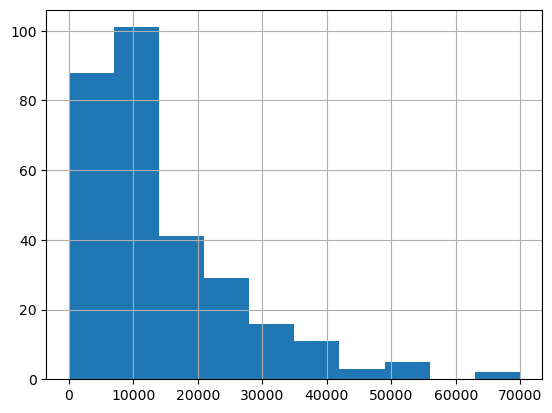

In [148]:
eu[eu.overpaid_ride_ticket == 1].distance.hist()
plt.show()

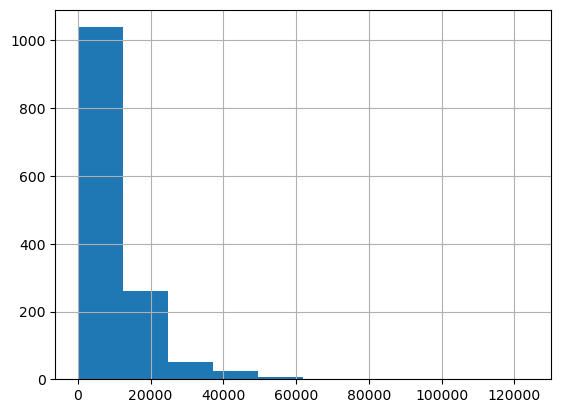

In [149]:
eu[eu.overpaid_ride_ticket == 0].distance.hist()
plt.show()

In [141]:
eu[eu.overpaid_ride_ticket == 1].distance.describe().round(1)

count      296.0
mean     14244.8
std      12093.9
min          0.0
25%       6155.2
50%      10701.0
75%      19763.2
max      69921.0
Name: distance, dtype: float64

In [145]:
eu[eu.overpaid_ride_ticket == 0].distance.describe().round(2)

count      1386.00
mean       9591.32
std       10102.60
min           0.00
25%        3182.75
50%        7338.50
75%       12402.50
max      123934.00
Name: distance, dtype: float64

In [157]:
over_diff = eu[eu.overpaid_ride_ticket == 1].distance - eu[eu.overpaid_ride_ticket == 1].predicted_distance

In [159]:
non_over_diff = eu[eu.overpaid_ride_ticket == 0].distance - eu[eu.overpaid_ride_ticket == 0].predicted_distance

In [160]:
over_diff.describe().round(1)

count      296.0
mean      4498.1
std      11118.5
min     -40157.0
25%       -628.2
50%        644.0
75%       9365.5
max      60276.0
dtype: float64

In [161]:
non_over_diff.describe().round(1)

count      1386.0
mean       -261.2
std       14537.2
min     -341860.0
25%       -1704.5
50%           0.0
75%        1544.0
max      112012.0
dtype: float64

### Систематически завышается актуальная дистанция

In [157]:
over_diff = eu[eu.overpaid_ride_ticket == 1].distance - eu[eu.overpaid_ride_ticket == 1].predicted_distance

In [159]:
non_over_diff = eu[eu.overpaid_ride_ticket == 0].distance - eu[eu.overpaid_ride_ticket == 0].predicted_distance

In [160]:
over_diff.describe().round(1)

count      296.0
mean      4498.1
std      11118.5
min     -40157.0
25%       -628.2
50%        644.0
75%       9365.5
max      60276.0
dtype: float64

In [161]:
non_over_diff.describe().round(1)

count      1386.0
mean       -261.2
std       14537.2
min     -341860.0
25%       -1704.5
50%           0.0
75%        1544.0
max      112012.0
dtype: float64

А длительность вроде не сильно увеличивается

In [177]:
over_diff = eu[eu.overpaid_ride_ticket == 1].duration - eu[eu.overpaid_ride_ticket == 1].predicted_duration

In [178]:
non_over_diff = eu[eu.overpaid_ride_ticket == 0].duration - eu[eu.overpaid_ride_ticket == 0].predicted_duration

In [179]:
over_diff.describe().round(1)

count     296.0
mean      715.8
std      1427.5
min     -2757.0
25%       -65.5
50%       473.5
75%      1165.8
max      8962.0
dtype: float64

In [180]:
non_over_diff.describe().round(1)

count     1386.0
mean       753.8
std       2035.0
min     -20081.0
25%        -90.5
50%        370.0
75%       1281.8
max      18086.0
dtype: float64

сравним eu and non eu. Не особо отличаются.

In [113]:
eu_diff = df[df.eu_indicator == 1].distance - df[df.eu_indicator == 1].predicted_distance

In [114]:
non_eu_diff = df[df.eu_indicator == 0].distance - df[df.eu_indicator == 0].predicted_distance

In [115]:
eu_diff.describe().round(1)

count     2465.0
mean       837.3
std       4599.5
min     -47413.0
25%       -173.0
50%        202.0
75%       1482.0
max      48915.0
dtype: float64

In [116]:
non_eu_diff.describe().round(1)

count      1682.0
mean        576.3
std       14110.2
min     -341860.0
25%       -1453.8
50%          45.5
75%        2049.8
max      112012.0
dtype: float64

люди чаще возмущаются, когда цена выставляется не заранее, а по предсказанию. И цена почти в 2 раза чаще вычисляется предсказанием.

In [225]:
eu.groupby('prediction_price_type').overpaid_ride_ticket.value_counts().round(2)

prediction_price_type        overpaid_ride_ticket
prediction                   0                       794
                             1                       203
upfront                      0                       582
                             1                        90
upfront_destination_changed  0                        10
                             1                         3
Name: overpaid_ride_ticket, dtype: int64

Нет, часы, кажется, не влияют.

In [63]:
line1 = eu[eu.overpaid_ride_ticket == 0].hour.value_counts(normalize=True).reset_index().rename(columns={'hour': 'percent', 'index': 'hour'}).sort_values('hour')
line2 = eu[eu.overpaid_ride_ticket == 1].hour.value_counts(normalize=True).reset_index().rename(columns={'hour': 'percent', 'index': 'hour'}).sort_values('hour')

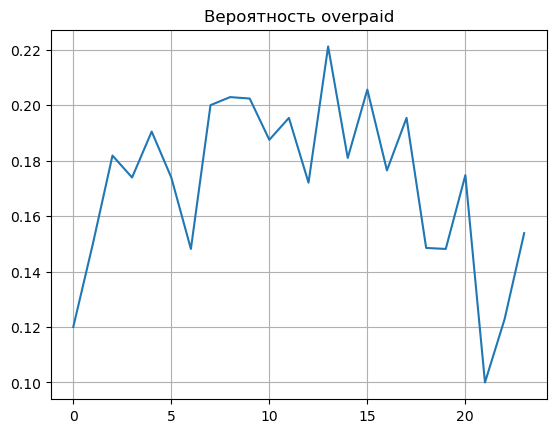

In [78]:
line_mean = eu.groupby('hour').overpaid_ride_ticket.mean().reset_index().sort_values('hour')
plt.plot(line_mean.hour, line_mean.overpaid_ride_ticket)
plt.grid()
plt.title('Вероятность overpaid')
plt.show()

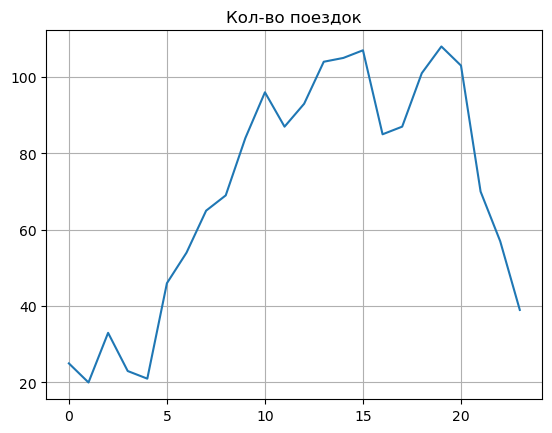

In [81]:
line_count = eu.groupby('hour').overpaid_ride_ticket.count().reset_index().sort_values('hour')
plt.plot(line_count.hour, line_count.overpaid_ride_ticket)
plt.grid()
plt.title('Кол-во поездок')
plt.show()

fraud

In [109]:
eu.fraud_score.notna().sum()

53

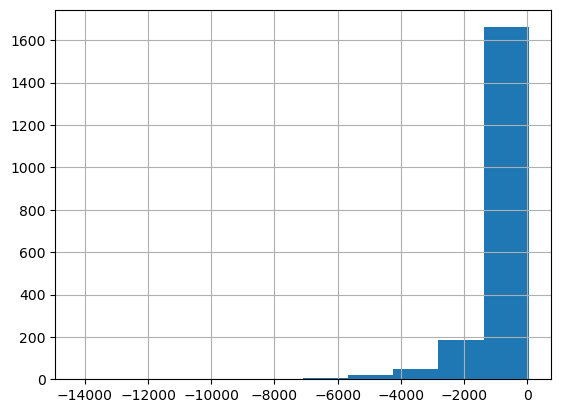

In [110]:
df.fraud_score.hist()
plt.show()

driverapp

In [82]:

app = eu.groupby('driver_app_version').overpaid_ride_ticket.agg([pd.Series.count, pd.Series.mean]).round(2).reset_index()
# .sort_values("mean", ascending=False)

In [91]:
app['num'] = app.driver_app_version.str.slice(3).sort_values()

In [93]:
app = app.sort_values('num')

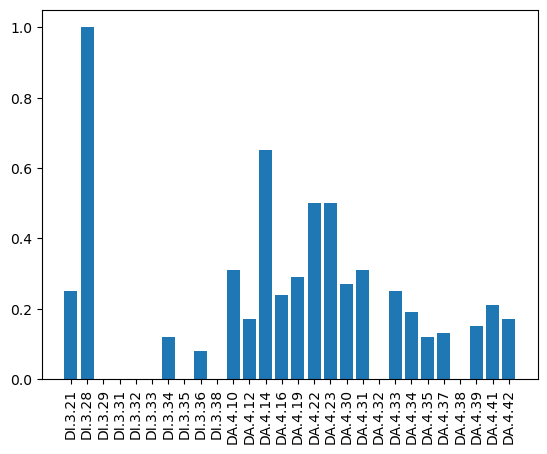

In [104]:
plt.bar(x=app.driver_app_version, height=app['mean'])
plt.xticks(rotation=90)
plt.show()

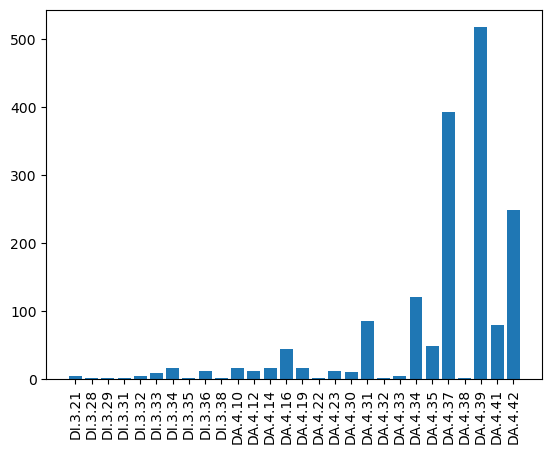

In [105]:
plt.bar(x=app.driver_app_version, height=app['count'])
plt.xticks(rotation=90)
plt.show()

отследить водителей по driver_device_uid_new

### Возможные косвенные причины, почему не в Европе может быть больше переплат

Поездки более длительные.

In [217]:
df[df.eu_indicator == 0].distance.describe().round(1)

count      1682.0
mean      10410.2
std       10625.5
min           0.0
25%        3575.5
50%        7989.0
75%       13203.2
max      123934.0
Name: distance, dtype: float64

In [218]:
df[df.eu_indicator == 1].distance.describe().round(1)

count      2484.0
mean       8854.5
std       10812.2
min           0.0
25%        3789.8
50%        6403.5
75%       10663.5
max      233190.0
Name: distance, dtype: float64

In [112]:
df.groupby('eu_indicator').gps_confidence.value_counts(normalize=True).round(2)

eu_indicator  gps_confidence
0             1                 0.61
              0                 0.39
1             1                 0.96
              0                 0.04
Name: gps_confidence, dtype: float64

In [77]:
df.groupby('eu_indicator').overpaid_ride_ticket.mean().round(2)

eu_indicator
0    0.18
1    0.01
Name: overpaid_ride_ticket, dtype: float64

In [77]:
df.groupby('eu_indicator').overpaid_ride_ticket.mean().round(2)

eu_indicator
0    0.18
1    0.01
Name: overpaid_ride_ticket, dtype: float64

Между Европой и не Европой отличается, что в Европе цена сильнее привязана к длительности поездки. И upfront в Европе сильно привязана к итоговой цене.

In [141]:
df[df.eu_indicator == 1].corr()['metered_price'].sort_values()

gps_confidence          -0.108967
driver_device_uid_new   -0.039324
month                   -0.021148
order_id_new            -0.016272
order_try_id_new        -0.016271
hour                    -0.002962
cnt                      0.017028
overpaid_ride_ticket     0.055566
fraud_score              0.061567
dest_change_number       0.281349
predicted_duration       0.738075
predicted_distance       0.782791
duration                 0.844615
upfront_price            0.895811
distance                 0.911133
metered_price            1.000000
device_token                  NaN
eu_indicator                  NaN
Name: metered_price, dtype: float64

In [142]:
df[df.eu_indicator == 0].corr()['metered_price'].sort_values()

gps_confidence          -0.251502
fraud_score             -0.163955
month                   -0.077670
driver_device_uid_new   -0.073789
order_try_id_new        -0.073358
order_id_new            -0.073355
hour                     0.022013
cnt                      0.049362
dest_change_number       0.097146
overpaid_ride_ticket     0.121605
upfront_price            0.227041
predicted_distance       0.319781
predicted_duration       0.379433
duration                 0.533563
distance                 0.897103
metered_price            1.000000
device_token                  NaN
eu_indicator                  NaN
Name: metered_price, dtype: float64

In [148]:
cor_cols = ['metered_price', 'upfront_price', 'distance', 'duration', 'gps_confidence', 'predicted_distance', 'predicted_duration']

In [150]:
df[df.eu_indicator == 0][cor_cols].corr().round(2)

,metered_price,upfront_price,distance,duration,gps_confidence,predicted_distance,predicted_duration
metered_price,1.00,0.23,0.90,0.53,-0.25,0.32,0.38
upfront_price,0.23,1.00,0.19,0.11,-0.04,0.97,0.90
distance,0.90,0.19,1.00,0.46,-0.28,0.30,0.39
duration,0.53,0.11,0.46,1.00,-0.24,0.22,0.36
gps_confidence,-0.25,-0.04,-0.28,-0.24,1.00,-0.08,-0.13
predicted_distance,0.32,0.97,0.30,0.22,-0.08,1.00,0.91
predicted_duration,0.38,0.90,0.39,0.36,-0.13,0.91,1.00


In [149]:
df[df.eu_indicator == 1][cor_cols].corr().round(2)

,metered_price,upfront_price,distance,duration,gps_confidence,predicted_distance,predicted_duration
metered_price,1.00,0.90,0.91,0.84,-0.11,0.78,0.74
upfront_price,0.90,1.00,0.87,0.67,-0.05,0.93,0.87
distance,0.91,0.87,1.00,0.76,-0.08,0.91,0.81
duration,0.84,0.67,0.76,1.00,-0.17,0.63,0.68
gps_confidence,-0.11,-0.05,-0.08,-0.17,1.00,-0.06,-0.07
predicted_distance,0.78,0.93,0.91,0.63,-0.06,1.00,0.90
predicted_duration,0.74,0.87,0.81,0.68,-0.07,0.90,1.00


цены аналогичные

In [66]:
price0 = df[df.eu_indicator == 0].metered_price
price1 = df[df.eu_indicator == 1].metered_price

In [68]:
price0 = (price0 - price0.mean()) / price0.std()
price1 = (price1 - price1.mean()) / price1.std()

In [72]:
price0.describe().round(3)

count    1682.000
mean       -0.000
std         1.000
min        -0.828
25%        -0.612
50%        -0.279
75%         0.151
max         9.596
Name: metered_price, dtype: float64

In [73]:
price1.describe().round(3)

count    2465.000
mean       -0.000
std         1.000
min        -0.802
25%        -0.514
50%        -0.244
75%         0.167
max        16.075
Name: metered_price, dtype: float64

### управление настроением

насколько люди расстраиваются из-за несоответствий с расстоянием в зависимости от  prediction_price_type

In [124]:
df[df.eu_indicator == 1].metered_price.describe().round(2)

count    2465.00
mean        7.58
std         6.96
min         2.00
25%         4.00
50%         5.88
75%         8.74
max       119.43
Name: metered_price, dtype: float64

In [125]:
df[df.eu_indicator == 0].metered_price.describe().round(2)

count      1682.00
mean      17294.73
std       18464.66
min        2000.00
25%        6000.00
50%       12142.59
75%       20084.58
max      194483.52
Name: metered_price, dtype: float64

In [133]:
eu.groupby(['overpaid_ride_ticket', 'prediction_price_type']).over_distance.agg(np.median).round(2)

overpaid_ride_ticket  prediction_price_type      
0                     prediction                         0.0
                      upfront                          109.5
                      upfront_destination_changed     6285.5
1                     prediction                       616.0
                      upfront                          626.5
                      upfront_destination_changed    20673.0
Name: over_distance, dtype: float64

In [134]:
eu.groupby(['prediction_price_type', 'overpaid_ride_ticket']).over_distance.agg(np.median).round(2)

prediction_price_type        overpaid_ride_ticket
prediction                   0                           0.0
                             1                         616.0
upfront                      0                         109.5
                             1                         626.5
upfront_destination_changed  0                        6285.5
                             1                       20673.0
Name: over_distance, dtype: float64

вроде лучше строить регрессию, чем оценивать корреляции отдельно

In [159]:
from sklearn.linear_model import LinearRegression

In [160]:
lr = LinearRegression()

In [166]:
df[df.eu_indicator == 1][cor_cols].drop(columns='metered_price')

,upfront_price,distance,duration,gps_confidence,predicted_distance,predicted_duration
0,10.0,2839,700,1,13384.0,1091.0
1,3.6,5698,493,1,2286.0,360.0
2,3.5,4426,695,1,4101.0,433.0
5,6.3,4924,513,1,4882.0,562.0
7,6.5,2020,412,1,8545.0,888.0
...,...,...,...,...,...,...
4071,6.3,9574,5093,1,9511.0,1324.0
4094,4.0,4281,2332,1,3944.0,513.0
4096,NaN,73533,8809,0,30683.0,2506.0
4104,9.9,39579,4581,1,19332.0,1396.0


In [171]:
df[df.eu_indicator == 1][cor_cols].drop(columns='metered_price').dropna()

,upfront_price,distance,duration,gps_confidence,predicted_distance,predicted_duration
0,10.0,2839,700,1,13384.0,1091.0
1,3.6,5698,493,1,2286.0,360.0
2,3.5,4426,695,1,4101.0,433.0
5,6.3,4924,513,1,4882.0,562.0
7,6.5,2020,412,1,8545.0,888.0
...,...,...,...,...,...,...
4061,8.1,3528,338,1,8143.0,768.0
4071,6.3,9574,5093,1,9511.0,1324.0
4094,4.0,4281,2332,1,3944.0,513.0
4104,9.9,39579,4581,1,19332.0,1396.0


In [187]:
X = df[df.eu_indicator == 0][cor_cols].dropna().drop(columns='metered_price')
y = df[df.eu_indicator == 0][cor_cols].dropna()['metered_price']

In [188]:
X = (X - X.mean()) / X.std()

In [190]:
lr.fit(X, y)

LinearRegression()

In [191]:
lr.coef_

array([ 16398.67893295,  18445.50962158,   1628.64462669,   -313.27310737,
       -15417.7859844 ,   -316.76282389])

In [192]:
X.columns

Index(['upfront_price', 'distance', 'duration', 'gps_confidence',
       'predicted_distance', 'predicted_duration'],
      dtype='object')